In [23]:
#This code test the multi-omics results. It displays the epigenetic matrices call for the A/B compartments. 
#It then diplays the mnultiomics call the the A/B compartments. 

#First Panel Gets the Data
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import scipy
import pyBigWig
import math
import seaborn as sns
from scipy import stats

resolution = 1000000
path = '/projects/b1198/epifluidlab/david/GSE63525/GM12878/'
chromosome = 14
chromosome_string = 'chr' + str(chromosome)

def load_and_replace_nan(file_path):
    data = np.loadtxt(file_path)
    #data[np.isnan(data)] = 0
    return data

def calculate_bin_averages(data, elements_per_bin):
    num_bins = math.ceil(len(data)/elements_per_bin)
    bin_averages = np.zeros(num_bins)
    for i in range(num_bins):
        start_index = i * elements_per_bin
        end_index = min((i + 1) * elements_per_bin, len(data))
        bin_data = data[start_index:end_index]
        if len(bin_data) > 0:
            bin_averages[i] = np.mean(bin_data)
        else:
            bin_averages[i] = 0
    return np.nan_to_num(bin_averages, nan=0.0)

sol_factors_by_ch = {}
correlation_by_ch = []
p_values_by_ch = []
active_factors_by_ch = {}
passive_factors_by_ch = {}
aiden_active_by_ch = {}
removed_rowIndices_by_ch = {ch: [] for ch in range(1, 23)}
filtered_indices_ch = {ch: [] for ch in range(1, 23)}
active_factor_genome_wide = []
active_factor_genome_wide_centromere_filtered = []
active_factor_genome_wide_centromere_filtered_outliers_removed = []
passive_factor_genome_wide = []
passive_factor_genome_wide_centromere_filtered = []
passive_factor_genome_wide_centromere_filtered_outliers_removed = []
aiden_acitve_factor_genome_wide = []
aiden_active_factor_genome_wide_centromere_filtered = []
aiden_active_factor_genome_wide_centromere_filtered_outliers_removed = []

for ch in range(1, 23):
    ch_string = 'chr' + str(ch)
    
    mat_file = path + f'Workspaces/individual/ch{ch}_res{resolution}_structedData_2Downsampled_H3K9me3_fold_change_small_100_first2_300iterations_translated.mat'
    data = scipy.io.loadmat(mat_file)
    sol_factors_by_ch[ch] = data['sol_factors']
    vector1 = sol_factors_by_ch[ch][0, 1][0,0][:, 0]
    vector2 = sol_factors_by_ch[ch][0, 1][0,0][:, 1]
    
    removed_rows_path = path + f'Workspaces/individual/ch{ch}_res{resolution}_observed_NONE_removedRows.mat'
    data2 = scipy.io.loadmat(removed_rows_path)
    removed_rowIndices_by_ch[ch] = data2['removed_rows_indices']
    N_ch = sol_factors_by_ch[ch][0,1][0,0][:, 0].size
    filtered_indices_ch[ch] = [i for i in range(N_ch) if i not in removed_rowIndices_by_ch[ch]]
      
    new_path = '/projects/b1198/epifluidlab/david/Genomic_Files/BigWigFiles/hg19/active/'
    bigwigfile1 = new_path + 'ENCFF154XCY_hg19_H3K4me3_GM12878.bigWig'
    bw_file1 = pyBigWig.open(bigwigfile1)
    start = 0
    end = bw_file1.chroms()[ch_string]
    data1 = bw_file1.values(ch_string, start, end)
    bin_averages1 = calculate_bin_averages(data1, resolution)
    bin_averages1_filtered = bin_averages1[filtered_indices_ch[ch]]
    
    correlation1 = np.corrcoef(vector1[filtered_indices_ch[ch]], bin_averages1_filtered)[0, 1]
    correlation2 = np.corrcoef(vector2[filtered_indices_ch[ch]], bin_averages1_filtered)[0, 1]
    if correlation1 > correlation2:
        active_factor = vector1
        passive_factor = vector2
    else:
        active_factor = vector2
        passive_factor = vector1
        
    file_path = path + f'eigenvector/res{resolution}_ch{ch}_observed_NONE_NONE_eigenvector.txt'
    vector3 = load_and_replace_nan(file_path)
    vector4 = -vector3
    correlation1 = np.corrcoef(vector3[filtered_indices_ch[ch]], bin_averages1_filtered)[0, 1]
    correlation2 = np.corrcoef(vector4[filtered_indices_ch[ch]], bin_averages1_filtered)[0, 1]
    if correlation1 > correlation2:
        aiden_eigenvector = vector3
    else:
        aiden_eigenvector = vector4
    
    active_factor_genome_wide.extend(active_factor)
    active_factor_genome_wide_centromere_filtered.extend(active_factor[filtered_indices_ch[ch]])
    active_factors_by_ch[ch] = active_factor
    passive_factor_genome_wide.extend(passive_factor)
    passive_factor_genome_wide_centromere_filtered.extend(passive_factor[filtered_indices_ch[ch]])
    passive_factors_by_ch[ch] = passive_factor
    aiden_acitve_factor_genome_wide.extend(aiden_eigenvector)
    aiden_active_factor_genome_wide_centromere_filtered.extend(aiden_eigenvector[filtered_indices_ch[ch]])
    aiden_active_by_ch[ch] = aiden_eigenvector
    
    correlation, p_value = scipy.stats.pearsonr(active_factor[filtered_indices_ch[ch]], passive_factor[filtered_indices_ch[ch]])
    correlation_by_ch.append(correlation)
    p_values_by_ch.append(p_value)
    
    # Calculate central tendency and dispersion measures for each vector
    Q1_vector1 = np.percentile(active_factor[filtered_indices_ch[ch]], 25)
    Q3_vector1 = np.percentile(active_factor[filtered_indices_ch[ch]], 75)
    IQR_vector1 = Q3_vector1 - Q1_vector1
    threshold_vector1 = 1.5 * IQR_vector1

    Q1_vector2 = np.percentile(passive_factor[filtered_indices_ch[ch]], 25)
    Q3_vector2 = np.percentile(passive_factor[filtered_indices_ch[ch]], 75)
    IQR_vector2 = Q3_vector2 - Q1_vector2
    threshold_vector2 = 1.5 * IQR_vector2

    Q1_vector3 = np.percentile(aiden_eigenvector[filtered_indices_ch[ch]], 25)
    Q3_vector3 = np.percentile(aiden_eigenvector[filtered_indices_ch[ch]], 75)
    IQR_vector3 = Q3_vector3 - Q1_vector3
    threshold_vector3 = 1.5 * IQR_vector3
    
    # Find indices of outliers in each vector
    outliers_vector1 = np.where((active_factor[filtered_indices_ch[ch]]< Q1_vector1 - threshold_vector1) | (active_factor[filtered_indices_ch[ch]] > Q3_vector1 + threshold_vector1))
    outliers_vector2 = np.where((passive_factor[filtered_indices_ch[ch]] < Q1_vector2 - threshold_vector2) | (passive_factor[filtered_indices_ch[ch]] > Q3_vector2 + threshold_vector2))
    outliers_vector3 = np.where((aiden_eigenvector[filtered_indices_ch[ch]] < Q1_vector3 - threshold_vector3) | (aiden_eigenvector[filtered_indices_ch[ch]] > Q3_vector3 + threshold_vector3))
    
    # Combine the outlier indices from both vectors
    all_outliers_indices = np.union1d(outliers_vector1, outliers_vector2) 
    all_outliers_indices = np.union1d(all_outliers_indices, outliers_vector3)
    
    # Remove the identified indices from both vectors
    filtered_vector1 = np.delete(active_factor[filtered_indices_ch[ch]], all_outliers_indices)
    filtered_vector2 = np.delete(passive_factor[filtered_indices_ch[ch]], all_outliers_indices)
    filtered_vector3 = np.delete(aiden_eigenvector[filtered_indices_ch[ch]], all_outliers_indices)
    
    active_factor_genome_wide_centromere_filtered_outliers_removed.extend(filtered_vector1)
    passive_factor_genome_wide_centromere_filtered_outliers_removed.extend(filtered_vector2)
    aiden_active_factor_genome_wide_centromere_filtered_outliers_removed.extend(filtered_vector3)           
                                 


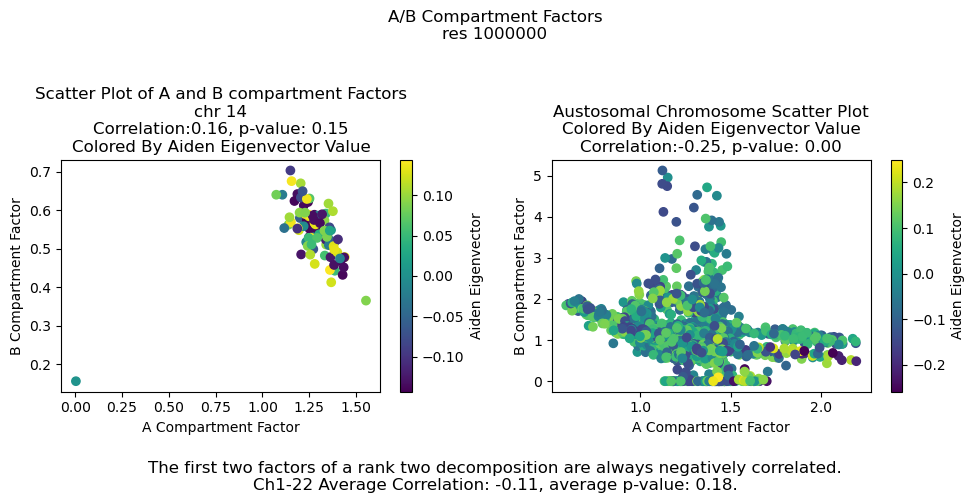

In [26]:
chromosome = 14

# Create a figure with two subplots
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle(f'A/B Compartment Factors\nres {resolution}')

average_p_value = np.mean(p_values_by_ch)
average_correlation = np.mean(correlation_by_ch)

#axis1
#A and B factors colored by Aiden Eigenvector
correlation_coefficient, p_value = scipy.stats.pearsonr(active_factors_by_ch[chromosome][filtered_indices_ch[chromosome]], passive_factors_by_ch[chromosome][filtered_indices_ch[chromosome]])
vector3 = aiden_active_by_ch[chromosome][filtered_indices_ch[chromosome]] 
vmin, vmax = np.min(vector3), np.max(vector3)
sc = ax1.scatter(active_factors_by_ch[chromosome][filtered_indices_ch[chromosome]], passive_factors_by_ch[chromosome][filtered_indices_ch[chromosome]], c=vector3, cmap='viridis', vmin=vmin, vmax=vmax)
ax1.set_title(f'Scatter Plot of A and B compartment Factors\nchr {chromosome}\nCorrelation:{correlation_coefficient:.2f}, p-value: {p_value:.2f}\nColored By Aiden Eigenvector Value')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax1)
cbar.set_label('Aiden Eigenvector')
ax1.set_xlabel('A Compartment Factor')
ax1.set_ylabel('B Compartment Factor')

#axis2
#genome_wide figure of A and B Factors colored by Aiden Eigenvector
vmin, vmax = np.min(aiden_active_factor_genome_wide_centromere_filtered_outliers_removed), np.max(aiden_active_factor_genome_wide_centromere_filtered_outliers_removed)
correlation_coefficient_genome_wide, p_value_genome_wide = scipy.stats.pearsonr(active_factor_genome_wide_centromere_filtered_outliers_removed, passive_factor_genome_wide_centromere_filtered_outliers_removed)
sc = ax2.scatter(active_factor_genome_wide_centromere_filtered_outliers_removed, passive_factor_genome_wide_centromere_filtered_outliers_removed, c=aiden_active_factor_genome_wide_centromere_filtered_outliers_removed, cmap='viridis',vmin=vmin, vmax=vmax)
ax2.set_title(f'Austosomal Chromosome Scatter Plot\nColored By Aiden Eigenvector Value\nCorrelation:{correlation_coefficient_genome_wide:.2f}, p-value: {p_value_genome_wide:.2f}')
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax2)
cbar.set_label('Aiden Eigenvector')
ax2.set_xlabel('A Compartment Factor')
ax2.set_ylabel('B Compartment Factor')

caption = f'The first two factors of a rank two decomposition are always negatively correlated.\nCh1-22 Average Correlation: {average_correlation:.2f}, average p-value: {average_p_value:.2f}.'
fig.text(0.5, 0.02, caption, ha='center', fontsize=12)
plt.tight_layout(rect=[0, 0.1, 1, 0.95])



In [17]:
%lsmagic

Available line magics:
%alias  %alias_magic  %autoawait  %autocall  %automagic  %autosave  %bookmark  %cat  %cd  %clear  %colors  %conda  %config  %connect_info  %cp  %debug  %dhist  %dirs  %doctest_mode  %ed  %edit  %env  %gui  %hist  %history  %killbgscripts  %ldir  %less  %lf  %lk  %ll  %load  %load_ext  %loadpy  %logoff  %logon  %logstart  %logstate  %logstop  %ls  %lsmagic  %lx  %macro  %magic  %man  %matplotlib  %mkdir  %more  %mv  %notebook  %page  %pastebin  %pdb  %pdef  %pdoc  %pfile  %pinfo  %pinfo2  %pip  %popd  %pprint  %precision  %prun  %psearch  %psource  %pushd  %pwd  %pycat  %pylab  %qtconsole  %quickref  %recall  %rehashx  %reload_ext  %rep  %rerun  %reset  %reset_selective  %rm  %rmdir  %run  %save  %sc  %set_env  %store  %sx  %system  %tb  %time  %timeit  %unalias  %unload_ext  %who  %who_ls  %whos  %xdel  %xmode

Available cell magics:
%%!  %%HTML  %%SVG  %%bash  %%capture  %%debug  %%file  %%html  %%javascript  %%js  %%latex  %%markdown  %%perl  %%prun  %%pypy  %%